## Prep

In [1]:
import pandas as pd
from functions_file import sensor_scenarios
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# print all sensor scenarios
scenarios = []
for scenario in sensor_scenarios:
    inVar = list(set([a[2:] for a in sensor_scenarios[scenario][0]]))
    outVar = list(set([a[2:] for a in sensor_scenarios[scenario][1]]))
    scenarios.append([scenario,inVar,outVar])
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(scenarios))

,0,1,2
0,Scen0_qk,[all_LD],"[all_MS, Car_MS, Taxi_MS, Medium Vehicle_MS, Bus_MS, Motorcycle_MS]"
1,Scen1_qk,"[Car0050_MS, Taxi_MS, all_LD]","[all_MS, Car_MS, Medium Vehicle_MS, Bus_MS, Motorcycle_MS]"
2,Scen2_qk,"[Car0050_MS, Taxi_MS, Bus_MS]","[all_MS, Car_MS, Medium Vehicle_MS, all_LD, Motorcycle_MS]"
3,Scen3_qk,"[Car0050_MS, Bus_MS, all_LD]","[all_MS, Car_MS, Taxi_MS, Medium Vehicle_MS, Motorcycle_MS]"
4,Scen4_qk,"[Taxi_MS, Bus_MS, all_LD]","[all_MS, Motorcycle_MS, Medium Vehicle_MS, Car_MS]"
5,Scen5_qk,"[Car0050_MS, Taxi_MS]","[all_MS, Motorcycle_MS, Medium Vehicle_MS, all_LD, Bus_MS, Car_MS]"
6,Scen6_qk,"[Taxi_MS, Bus_MS]","[all_MS, Car_MS, Medium Vehicle_MS, all_LD, Motorcycle_MS]"
7,Scen7_qk,"[Taxi_MS, all_LD]","[all_MS, Car_MS, Medium Vehicle_MS, Bus_MS, Motorcycle_MS]"
8,Scen8_qk,"[Bus_MS, all_LD]","[all_MS, Car_MS, Taxi_MS, Medium Vehicle_MS, Motorcycle_MS]"
9,Scen9_qk,"[Car0050_MS, Bus_MS]","[all_MS, Car_MS, Taxi_MS, Medium Vehicle_MS, all_LD, Motorcycle_MS]"


In [3]:
# import result files for each method
numpolygons = 10
if numpolygons == 10:
    MLR = pd.read_pickle('../output/results_runs/MLR_lr04_e500_p10.pkl')
    MLRFD = pd.read_pickle('../output/results_runs/MLRFD_lr04_e500_p10.pkl') 
    #MLRFD = pd.read_pickle('../output/results_runs/MLRFD_lr04_e500_p10_FD2.pkl')
    NN = pd.read_pickle('../output/results_runs/NN7_lr001_b256_e1000_p10.pkl')
    NNFD = pd.read_pickle('../output/results_runs/NNFD7_lr001_b256_e500_p10.pkl')
    MLRLDD = pd.read_pickle('../output/results_runs/MLR_LDD_lr04_e500_p10.pkl')
    NNLDD = pd.read_pickle('../output/results_runs/NN7_LDD_lr001_b256_e1000_p10.pkl')
    MLRFDLDD = pd.read_pickle('../output/results_runs/MLRFD_LDD_lr04_e500_p10.pkl')
    NNFDLDD = pd.read_pickle('../output/results_runs/NNFD7_LDD_lr001_b256_e500_p10.pkl')

In [4]:
# gather all in one dataframe # separate q and k rows
allall = []
for method in [MLR,MLRFD,NN,NNFD,MLRLDD,NNLDD,MLRFDLDD,NNFDLDD]:
    for i,row in method.iterrows():
        FDFactor = row.Params[6:] if row.Params!='-' else 0
        for var in range(len(row.MAE)):
            allall.append([row.Scenario,row.Method,row.Params,row.Pol,row.Run,\
                           row.Cols[var][2:],row.Cols[var][0],row.Outliers,str(FDFactor),\
                           row.MAE[var],row.MAPE[var],row.RMSE[var],row.R2[var]])
allall = pd.DataFrame(allall,columns=['Scenario','Method','Params','Pol','Run','Mode','Var','Outliers','FDFactor','MAE','MAPE','RMSE','R2'])
    
# save as csv (previously pickle file)
#allall.to_csv('../output/results_runs/allresults_p%s.csv'%(numpolygons))

In [5]:
print('OLD')
print('Names:',set(allall.Method))
print('Modes:',set(allall['Mode']))
print('Variables:',set(allall['Var']))

# 1. rename methods 
rename = {'NN7_001':'NN','NN7_LDD_0002':'NN','MLR_LDD':'MLR','NNFD7_001_03_06':'NNFD'}
allall = allall.replace({"Method": rename})

# 2. rename factors
rename = {'0':'0',\
          '[0]':'0','[0.3]':'0.3','[0.6]':'0.6',\
          '[0, 0]':'0','[0.3, 0.3]':'0.3','[0.6, 0.6]':'0.6',}
allall = allall.replace({"FDFactor": rename})

# 3. unique method name
allall['MethodUnique'] = allall.Method + '_' + allall.FDFactor

# 4. clean up mode and velocities : m_t,m_o + v --> m + v_o,v_t
modes = list(set(allall['Mode']))
for t in [a for a in modes if a.endswith('Target')]:
    idcs = allall[allall['Mode']==t].index.values
    ### MUST BE SWAPPED BECAUSE WERE SWAPPED IN PREV STEP (FIXED NOW) ###
    allall.loc[idcs,'Var'] = 'vOrig' # vTarget
    allall.loc[idcs,'Mode'] = [a[:-7] for a in allall.loc[idcs,'Mode']]
for t in [a for a in modes if a.endswith('Orig')]:
    idcs = allall[allall['Mode']==t].index.values
    ### MUST BE SWAPPED BECAUSE WERE SWAPPED IN PREV STEP (FIXED NOW) ###
    allall.loc[idcs,'Var'] = 'vTarget' # vOrig
    allall.loc[idcs,'Mode'] = [a[:-5] for a in allall.loc[idcs,'Mode']]

# 5. check 
print('\nNEW')
print('Names:',set(allall.Method))
print('FDFactors:',set(allall.FDFactor))
print('Modes:',set(allall['Mode']))
print('Variables:',set(allall['Var']))
print('Methods:',set(allall.MethodUnique))

OLD
Names: {'NN7_LDD_0002', 'MLR', 'MLRFD', 'NN7_001', 'MLR_LDD', 'NNFD7_001_03_06'}
Modes: {'all_LD', 'Medium Vehicle_MS_Target', 'Taxi_MS_Orig', 'all_MS', 'all_MS_Orig', 'all_LD_Orig', 'Taxi_MS', 'all_LD_Target', 'Car_MS_Target', 'Motorcycle_MS_Target', 'Car_MS', 'Bus_MS', 'Car_MS_Orig', 'Medium Vehicle_MS', 'Motorcycle_MS_Orig', 'Motorcycle_MS', 'Medium Vehicle_MS_Orig', 'Bus_MS_Orig', 'Bus_MS_Target', 'all_MS_Target', 'Taxi_MS_Target'}
Variables: {'v', 'k', 'q'}

NEW
Names: {'MLR', 'NN', 'MLRFD', 'NNFD'}
FDFactors: {'0.6', '0', '0.3'}
Modes: {'all_MS', 'Car_MS', 'Taxi_MS', 'Medium Vehicle_MS', 'all_LD', 'Bus_MS', 'Motorcycle_MS'}
Variables: {'vTarget', 'vOrig', 'k', 'q'}
Methods: {'MLRFD_0.3', 'MLRFD_0.6', 'NN_0', 'NNFD_0.3', 'MLRFD_0', 'MLR_0', 'NNFD_0.6', 'NNFD_0'}


## Look at data

In [6]:
# look at data
allall[(allall.MethodUnique=='MLRFD_0.6') & (allall['Mode']=='all_MS') & (allall['Var'].isin(['vTarget']))\
       & (allall['Pol']=='total') & (allall.Scenario=='Scen6_qk')].head(40)

,Scenario,Method,Params,Pol,Run,Mode,Var,Outliers,FDFactor,MAE,MAPE,RMSE,R2,MethodUnique
51123,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,0,all_MS,vTarget,8,0.6,3.253516,0.210055,5.510133,0.773891,MLRFD_0.6
52563,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,1,all_MS,vTarget,7,0.6,3.267833,0.211669,5.426320,0.780905,MLRFD_0.6
54003,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,2,all_MS,vTarget,8,0.6,3.252456,0.210273,5.518082,0.773418,MLRFD_0.6
55443,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,3,all_MS,vTarget,13,0.6,3.271954,0.218965,5.301737,0.785951,MLRFD_0.6
56883,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,4,all_MS,vTarget,6,0.6,3.694927,0.246933,5.119681,0.817899,MLRFD_0.6
58323,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,5,all_MS,vTarget,3,0.6,3.740167,0.250918,5.158981,0.815308,MLRFD_0.6
59763,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,6,all_MS,vTarget,17,0.6,3.368364,0.226071,5.180870,0.795312,MLRFD_0.6
61203,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,7,all_MS,vTarget,15,0.6,3.347456,0.221156,5.256884,0.791630,MLRFD_0.6
62643,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,8,all_MS,vTarget,7,0.6,3.273264,0.214321,4.809145,0.824247,MLRFD_0.6
64083,Scen6_qk,MLRFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6, 0.6]",total,9,all_MS,vTarget,8,0.6,3.256075,0.209507,5.498504,0.775180,MLRFD_0.6


#### 1. General comparison of MLR and NN

In [7]:
# General comparison of MLR and NN

# version 1
scenariocols = ['Scen2_qk','Scen3_qk','Scen4_qk','Scen6_qk','Scen7_qk','Scen8_qk']
#scenariocols = set(allall.Scenario)
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) & (allall.Pol=='total')]
#subset_ = allall[(allall.MethodUnique.isin(['MLR_0','MLRFD_0'])) & (allall['Mode'].isin(['all_MS'])) & (allall.Var.isin(['q','k'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','Mode','MethodUnique','Scenario']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:,:,scenariocols].head(3))

for err in ['MAPE','R2']:
    grouped = subset.loc[:,:,:,scenariocols].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

# group differently - not by mode, only some modes
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) \
                 & (~allall['Mode'].isin(['Bus_MS','Medium Vehicle_MS','Taxi'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','MethodUnique']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:].head(3))
#print(subset['MAPE'].mean())

for err in ['MAPE','R2']:
    grouped = subset.loc[:,:].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)
    
# compare scenario 1 to scenario 9
scenariocols = ['Scen1_qk','Scen9_qk']
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) \
                 & (~allall['Mode'].isin(['Bus_MS','all_LD','Taxi_MS'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','Mode','Scenario']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:,scenariocols].head(3))
for err in ['MAPE']:
    grouped = subset.loc[:,:,scenariocols].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)
    
# overall best scenario
scenariocols = set(allall.Scenario)
#scenariocols = ['Scen2_qk','Scen5_qk','Scen6_qk','Scen10_qk']
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) \
                 #& (allall['Mode'].isin(['Bus_MS','Medium Vehicle_MS']))\
                 #& (allall['Scenario'].isin(scenariocols))\
                 & (allall.Pol=='total')]
subset = subset_.groupby(by=['MethodUnique','Mode']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:,:].head(3))
for err in ['MAPE']:
    grouped = subset.loc[:,:,:].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)
    
# by mode - (q,k)
scenariocols = set(allall.Scenario)
#scenariocols = ['Scen2_qk','Scen5_qk','Scen6_qk','Scen10_qk']
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) \
                 #& (allall['Mode'].isin(['Bus_MS','Medium Vehicle_MS']))\
                 #& (allall['Scenario'].isin(scenariocols))\
                 & (allall.Pol=='total')]
subset = subset_.groupby(by=['MethodUnique','Scenario','Mode']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:,:,:].head(3))
for err in ['MAPE']:
    grouped = subset.loc[:,:,:,:].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)
subset = subset_.groupby(by=['Var','MethodUnique','Scenario','Mode']).mean().drop(columns='Run')
print('Length:',len(allall),'-->',len(subset_),'-->',len(subset))
display(subset.loc[:,:,:,:].head(3))
for err in ['MAE']:
    grouped = subset.loc[:,:,:,:].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

Length: 143040 --> 4640 --> 232


Outliers        MAE      MAPE       RMSE  \
Var Mode   MethodUnique Scenario                                             
k   Bus_MS MLR_0        Scen7_qk       0.0   4.035700  0.509769   5.283738   
           NN_0         Scen7_qk       0.0   3.860665  0.520625   4.984148   
    Car_MS MLR_0        Scen2_qk       0.0  16.856180  0.344802  24.133952   

                                        R2  
Var Mode   MethodUnique Scenario            
k   Bus_MS MLR_0        Scen7_qk  0.293896  
           NN_0         Scen7_qk  0.343849  
    Car_MS MLR_0        Scen2_qk  0.582218

Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


Results for R2


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


Length: 143040 --> 3360 --> 4


Outliers         MAE      MAPE        RMSE        R2
Var MethodUnique                                                      
k   MLR_0              0.0   14.880209  0.321996   22.996521  0.472393
    NN_0               0.0   11.538178  0.259851   17.437113  0.643809
q   MLR_0              0.0  249.611039  0.298917  374.962032  0.660457

Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:29: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


MethodUnique,MLR_0,NN_0
Var,,
k,0.32,0.26
q,0.30,0.25


Results for R2


MethodUnique,MLR_0,NN_0
Var,,
k,0.47,0.64
q,0.66,0.70


Length: 143040 --> 3520 --> 88


Outliers        MAE      MAPE       RMSE  \
Var Mode              Scenario                                             
k   Car_MS            Scen1_qk       0.0  12.193394  0.245982  19.020353   
                      Scen9_qk       0.0  17.828994  0.378634  25.901980   
    Medium Vehicle_MS Scen1_qk       0.0   4.335501  0.531064   5.938994   

                                      R2  
Var Mode              Scenario            
k   Car_MS            Scen1_qk  0.740776  
                      Scen9_qk  0.529250  
    Medium Vehicle_MS Scen1_qk  0.218375

Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:43: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


Length: 143040 --> 4640 --> 14


Outliers         MAE      MAPE        RMSE  \
MethodUnique Mode                                                            
MLR_0        Bus_MS                  0.0   34.646464  0.679909   53.653198   
             Car_MS                  0.0  101.851693  0.296165  154.505653   
             Medium Vehicle_MS       0.0   49.527920  0.706499   79.254891   

                                      R2  
MethodUnique Mode                         
MLR_0        Bus_MS             0.236549  
             Car_MS             0.623777  
             Medium Vehicle_MS  0.207556

Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:60: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\


Mode,Bus_MS,Car_MS,Medium Vehicle_MS,Motorcycle_MS,Taxi_MS,all_LD,all_MS
MethodUnique,,,,,,,
MLR_0,0.68,0.30,0.71,0.34,0.48,0.26,0.24
NN_0,1.03,0.24,0.78,0.28,0.43,0.23,0.18


Length: 143040 --> 4640 --> 116


Outliers         MAE      MAPE  \
MethodUnique Scenario Mode                                                
MLR_0        Scen0_qk Bus_MS                  0.0   35.026274  0.702368   
                      Car_MS                  0.0  101.006168  0.286298   
                      Medium Vehicle_MS       0.0   51.168230  0.728584   

                                               RMSE        R2  
MethodUnique Scenario Mode                                     
MLR_0        Scen0_qk Bus_MS              52.874570  0.224796  
                      Car_MS             152.309487  0.615345  
                      Medium Vehicle_MS   81.022228  0.176710

C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:77: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\


Results for MAPE


Length: 143040 --> 4640 --> 232


Outliers        MAE      MAPE  \
Var MethodUnique Scenario Mode                                               
k   MLR_0        Scen0_qk Bus_MS                  0.0   4.063896  0.517267   
                          Car_MS                  0.0  15.534808  0.306128   
                          Medium Vehicle_MS       0.0   4.644569  0.559663   

                                                  RMSE        R2  
Var MethodUnique Scenario Mode                                    
k   MLR_0        Scen0_qk Bus_MS              5.383321  0.281263  
                          Car_MS             25.898074  0.518833  
                          Medium Vehicle_MS   6.512681  0.151105

Results for MAE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\702611391.py:86: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\


In [8]:
# SPEEDS
subset_ = allall[#(allall.Method.isin(['MLR','NN'])) & \
                 ~(allall.Var.isin(['q','k'])) \
                 & (allall['Mode'].isin(['all_MS']))\
                 & (allall['Scenario'].isin(['Scen1_qk','Scen4_qk']))\
                 & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','Mode','MethodUnique']).mean().drop(columns='Run')
#subset = subset.groupby(by=['Var','MethodUnique','Mode']).min()
for err in ['MAPE']:
    grouped = subset.loc[:,:,:].unstack().drop(columns='Outliers')[err]\
    .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err,set(subset_.Var))
    display(grouped)

Results for MAPE {'vOrig', 'vTarget'}


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\3042901935.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(2)\


,MethodUnique,MLRFD_0,MLRFD_0.3,MLRFD_0.6,MLR_0,NNFD_0,NNFD_0.3,NNFD_0.6,NN_0
Var,Mode,,,,,,,,
vOrig,all_MS,0.19,0.19,0.19,0.61,0.15,0.15,0.15,0.43
vTarget,all_MS,0.17,0.17,0.17,0.38,0.13,0.13,0.13,0.20


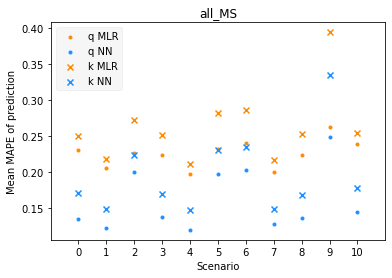

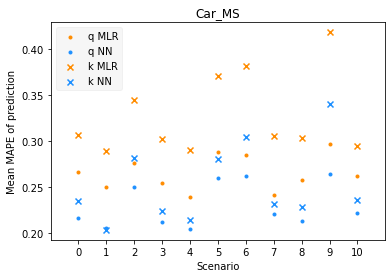

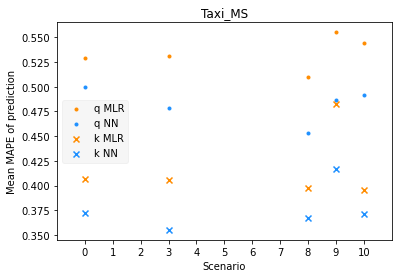

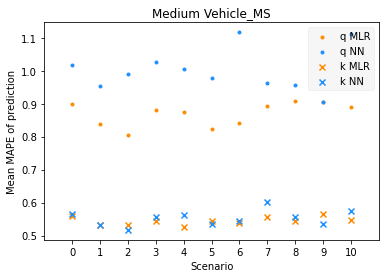

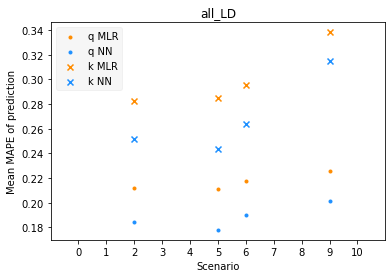

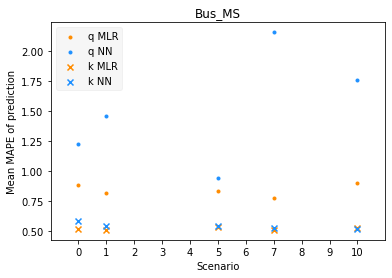

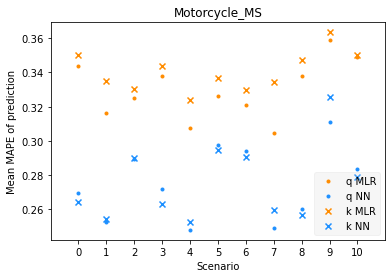

In [9]:
# PLOT 1 - OVERALL BY MODE

scenariocols = [0,1,2,3,4,5,6,7,8,9,10]
scenariocols = ['Scen%s_qk'%i for i in scenariocols]
err = 'MAPE'
colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','Mode','MethodUnique','Scenario']).mean().drop(columns='Run')
xxx = subset.loc[:,:,:,:][err]

for m in set(allall['Mode']):
    plt.figure()
    for vi,v in enumerate(['q','k']):
        for ai,a in enumerate(['MLR_0','NN_0']):
            for si,s in enumerate(scenariocols):
                try:
                    plt.scatter(int(s[4:-3]),xxx.loc[v,m,a,s],color=colors[ai],marker=markers[vi],label='%s %s'%(v,a[:-2]))
                except:
                    pass #print(m,a,s)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray') # ,loc=(0.1,0.7)
    plt.title(m)
    plt.xlim(-1,11); plt.xticks(range(0,11))
    plt.xlabel('Scenario'); plt.ylabel('Mean %s of prediction'%err)
    #plt.savefig('r1_%s.pdf'%(m), format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

#### 2. Effect of FD

In [10]:
# PLOT 2 - effect of FD

# 2.a.
subset_ = allall[(allall['Mode']=='all_MS') \
                 #& (allall.Method.isin(['MLRFD','NNFD'])) \
                 #& ~(allall.Var.isin(['vTarget','vOrig'])) \
                 & (allall.Scenario.isin(['Scen1_qk','Scen4_qk'])) \
                 & (allall.Pol=='total')]
subset = subset_[subset_.MAE!=np.inf].groupby(by=['Var','MethodUnique']).mean().drop(columns='Run')
for err in ['RMSE']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(axis=1, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)
    
# 2.b.
subset_ = allall[(allall['Mode']=='all_MS') & (allall.Method.isin(['MLRFD','NNFD'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Mode','MethodUnique','Scenario']).mean().drop(columns='Run')
for err in ['Outliers']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

Results for RMSE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\401094039.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=1, cmap="YlGnBu").set_precision(2)\


MethodUnique,MLRFD_0,MLRFD_0.3,MLRFD_0.6,MLR_0,NNFD_0,NNFD_0.3,NNFD_0.6,NN_0
Var,,,,,,,,
k,29.53,29.62,29.69,31.89,19.98,19.33,19.71,20.47
q,446.81,454.42,465.13,431.83,278.17,284.08,287.42,275.14
vOrig,4.58,4.48,4.42,50.05,3.95,3.98,3.53,8.40
vTarget,4.22,4.09,4.00,10.76,3.55,3.57,3.24,6.75


Results for Outliers


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\401094039.py:22: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


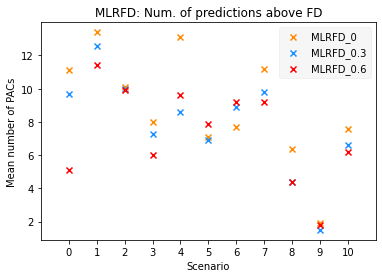

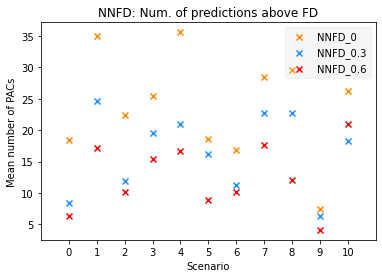

In [11]:
# PLOT FD OUTLIERS

scenariocols = [0,1,2,3,4,5,6,7,8,9,10]
scenariocols = ['Scen%s_qk'%i for i in scenariocols]
colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
subset_ = allall[(allall['Mode']=='all_MS') & (allall.Method.isin(['MLRFD','NNFD'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Mode','MethodUnique','Scenario']).mean().drop(columns='Run')
xxx = subset.loc[:,:,:]['Outliers']

for mi,m in enumerate(['MLRFD','NNFD']):
    plt.figure()
    for ai,a in enumerate(['%s_0'%m,'%s_0.3'%m,'%s_0.6'%m]):
        for si,s in enumerate(scenariocols):
            plt.scatter(int(s[4:-3]),xxx.loc[:,a,s],color=colors[ai],marker=markers[1],label='%s'%(a))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray') # ,loc=(0.1,0.7)
    plt.title('%s: Num. of predictions above FD'%m)
    plt.xlim(-1,11); plt.xticks(range(0,11))
    plt.xlabel('Scenario'); plt.ylabel('Mean number of PACs')
    #plt.savefig('r2_%s_Outliers.pdf'%(m), format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

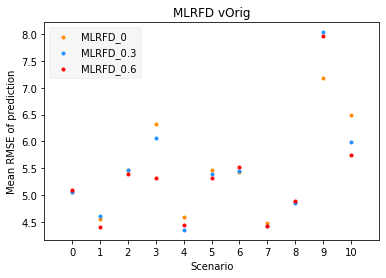

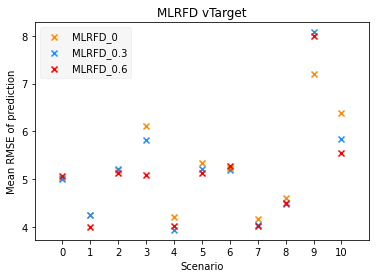

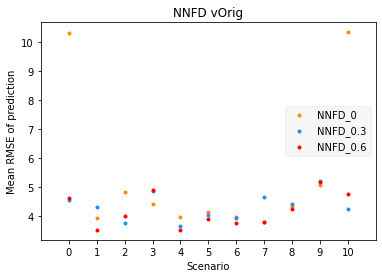

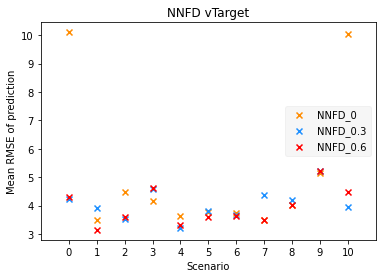

In [12]:
# PLOT FD RMSE BY SCENARIOS

scenariocols = [0,1,2,3,4,5,6,7,8,9,10]
scenariocols = ['Scen%s_qk'%i for i in scenariocols]
colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
subset_ = allall[(allall['Mode']=='all_MS') & (allall.Method.isin(['MLRFD','NNFD'])) & \
                 (allall.Var.isin(['vTarget','vOrig'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Mode','Var','MethodUnique','Scenario']).mean().drop(columns='Run')
err = 'RMSE'
xxx = subset.loc[:,:,:,:][err]

for mi,m in enumerate(['MLRFD','NNFD']):
    for vi,v in enumerate(['vOrig','vTarget']):
        plt.figure()
        for ai,a in enumerate(['%s_0'%m,'%s_0.3'%m,'%s_0.6'%m]):
            for si,s in enumerate(scenariocols):
                plt.scatter(int(s[4:-3]),xxx.loc[:,v,a,s],color=colors[ai],marker=markers[vi],label='%s'%(a))
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray') # ,loc=(0.1,0.7)
        plt.title('%s %s'%(m,v))
        plt.xlim(-1,11); plt.xticks(range(0,11))
        plt.xlabel('Scenario'); plt.ylabel('Mean %s of prediction'%err)
        #plt.savefig('r2_%s_%s_RMSE.pdf'%(m,v), format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()

In [13]:
# plot to table

subset_ = allall[(allall['Mode'].isin(['all_MS'])) \
                 & (allall.Method.isin(['MLRFD','NNFD'])) \
                 & (allall.Var.isin(['vTarget'])) \
                 #& (allall.Scenario.isin(['Scen4_qk','Scen10_qk'])) \
                 & (allall.Pol=='total')]
subset = subset_.groupby(by=['MethodUnique','Mode','Scenario']).mean().drop(columns='Run')
for err in ['RMSE']: # 'RMSE','R2','Outliers','MAE'
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(5)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

Results for RMSE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\2030708089.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=0, cmap="YlGnBu").set_precision(5)\


,Scenario,Scen0_qk,Scen10_qk,Scen1_qk,Scen2_qk,Scen3_qk,Scen4_qk,Scen5_qk,Scen6_qk,Scen7_qk,Scen8_qk,Scen9_qk
MethodUnique,Mode,,,,,,,,,,,
MLRFD_0,all_MS,5.02311,6.37633,4.24262,5.19021,6.10807,4.20530,5.33739,5.22518,4.16899,4.59354,7.19617
MLRFD_0.3,all_MS,4.99448,5.84325,4.25158,5.20459,5.81763,3.93199,5.21508,5.18965,4.03530,4.48035,8.07729
MLRFD_0.6,all_MS,5.06772,5.54518,3.98801,5.13234,5.07318,4.01080,5.11721,5.27803,4.01553,4.50233,7.99317
NNFD_0,all_MS,10.10572,10.02982,3.48405,4.47405,4.18046,3.62292,3.77382,3.74460,3.48305,4.02668,5.13580
NNFD_0.3,all_MS,4.23732,3.96364,3.92594,3.53935,4.58835,3.20699,3.81758,3.67065,4.39183,4.18907,5.21601
NNFD_0.6,all_MS,4.29997,4.47745,3.14576,3.58992,4.61496,3.32733,3.59463,3.63639,3.49982,4.02767,5.21737


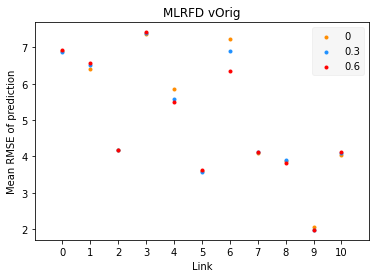

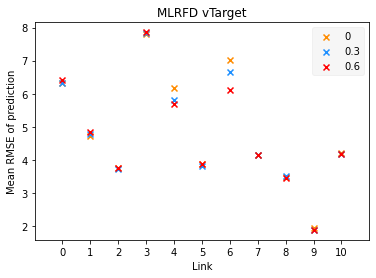

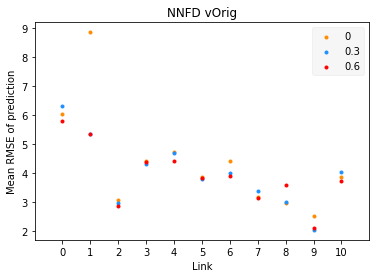

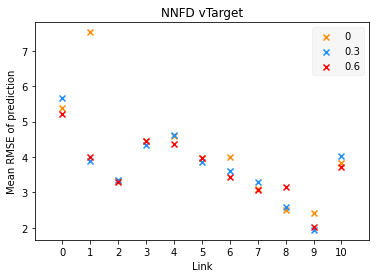

In [14]:
# PLOT FD RMSE BY POLYGON

colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
subset_ = allall[(allall['Mode']=='all_MS') & (allall.Method.isin(['MLRFD','NNFD'])) \
                 & (allall.Var.isin(['vTarget','vOrig'])) & (allall.Pol!='total') \
                 #& (allall.Scenario.isin(['Scen9_qk'])) \
                ]
subset = subset_.groupby(by=['Mode','Var','MethodUnique','Pol']).mean().drop(columns='Run')
err = 'RMSE'
xxx = subset.loc[:,:,:,:][err]

for mi,m in enumerate(['MLRFD','NNFD']):
    for vi,v in enumerate(['vOrig','vTarget']):
        plt.figure()
        for ai,a in enumerate(['%s_0'%m,'%s_0.3'%m,'%s_0.6'%m]):
            for si,s in enumerate(set(subset_.Pol)):
                xpol = int(s[9:])
                xpol -= 1 if xpol>3 else 0
                plt.scatter(xpol,xxx.loc[:,v,a,s],color=colors[ai],marker=markers[vi],label='%s'%(a[len(m)+1:]))
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray') # ,loc=(0.1,0.7)
        plt.title('%s %s'%(m,v))
        plt.xlim(-1,11); plt.xticks(range(11))
        plt.xlabel('Link'); plt.ylabel('Mean %s of prediction'%err)
        #plt.savefig('r2_%s_%s_RMSE_polygon.pdf'%(m,v), format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()

#### 3. Bus stops and extra lanes

In [15]:
# PLOT 3 - busses

# merge allall and polygon info
polygons = pd.read_csv('../data/polygons11.csv')
print(polygons.columns.values)
tmp = pd.merge(allall, polygons, how="left", left_on='Pol',right_on='name')
busses = tmp[tmp['Mode']=='Bus_MS']
display(busses.tail(3))

# check if buslane relates to accuracy
subset_ = busses[(busses.Pol!='total')&(busses.Method.isin(['NN','MLR']))]
subset = subset_.groupby(by=['Mode','Var','Method','seplane','busstops','Scenario']).mean().drop(columns='Run')
for err in ['MAPE']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

# check if buslane relates to accuracy
busses = tmp[tmp['Mode'].isin(['all_LD'])]
subset_ = busses[(busses.Pol!='total')&(busses.Method.isin(['NN','MLR']))\
                #& (busses.Var.isin(['q','k'])) \
                & (busses['seplane']==0)\
                ]
subset = subset_.groupby(by=['Var','Method','busstops']).mean().drop(columns='Run')
for err in ['MAPE']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

['polygon' 'name' 'p0_lat_frontleft' 'p0_lon_frontleft'
 'p0_lat_frontright' 'p0_lon_frontright' 'p0_lat_backright'
 'p0_lon_backright' 'p0_lat_backleft' 'p0_lon_backleft' 'length' 'lanes'
 'direction' 'busstops' 'seplane' 'comment' 'complexity' 'road_rank']


,Scenario,Method,Params,Pol,Run,Mode,Var,Outliers,FDFactor,MAE,...,p0_lat_backleft,p0_lon_backleft,length,lanes,direction,busstops,seplane,comment,complexity,road_rank
140139,Scen0_qk,NN,-,polygon_r3,19,Bus_MS,k,0,0,4.072439,...,37.980877,23.730955,0.09,3.0,310.0,0.0,1.0,2 + cab/bus/motorcycle lane,1.0,0.0
140151,Scen0_qk,NN,-,polygon_r3,19,Bus_MS,vOrig,0,0,10.777523,...,37.980877,23.730955,0.09,3.0,310.0,0.0,1.0,2 + cab/bus/motorcycle lane,1.0,0.0
140157,Scen0_qk,NN,-,polygon_r3,19,Bus_MS,vTarget,0,0,10.837477,...,37.980877,23.730955,0.09,3.0,310.0,0.0,1.0,2 + cab/bus/motorcycle lane,1.0,0.0


Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\3274912047.py:15: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\3274912047.py:29: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(cmap="YlGnBu").set_precision(2)\


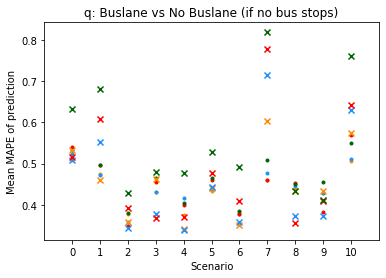

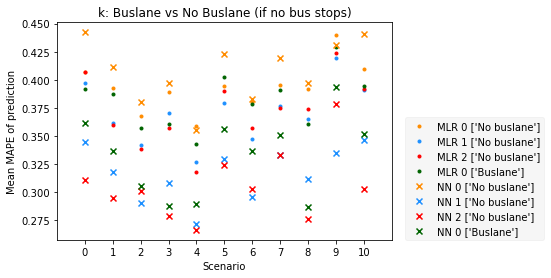

In [16]:
# PLOT BUSSES

scenariocols = range(0,11)#[1,5,7,10]
scenariocols = ['Scen%s_qk'%i for i in scenariocols]
colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
err = 'MAPE'
# data
tmp = pd.merge(allall, polygons, how="left", left_on='Pol',right_on='name')
busses = tmp[tmp['Mode']!='_Bus_MS']
subset_ = busses[(busses.Pol!='total')&(busses.Method.isin(['NN','MLR']))]
subset = subset_.groupby(by=['Var','Method','seplane','busstops','Scenario']).mean().drop(columns='Run')
xxx = subset.loc[:,:,:,:,:][err]

for vi,v in enumerate(['q','k']):
    plt.figure()
    for mi,m in enumerate(['MLR','NN']):
        for ai,a in enumerate([[0,0],[0,1],[0,2],[1,0]]): # buslane vs no buslane if no busstops
            for si,s in enumerate(scenariocols):
                plt.scatter(int(s[4:-3]),xxx.loc[v,m,a[0],a[1],s],color=colors[ai],marker=markers[mi],label='%s %s %s'%(m,a[1],['Buslane' if a[0]==1 else 'No buslane']))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if vi==1:
        plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray',loc=(1.04,0))
    plt.title('%s: Buslane vs No Buslane (if no bus stops)'%v)
    plt.xlim(-1,11); plt.xticks(range(11))
    plt.xlabel('Scenario'); plt.ylabel('Mean %s of prediction'%err)
    #plt.savefig('r3_%s_Buslane.pdf'%(v), format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

#### 4. Road rank

In [17]:
# PLOT 4 - road rank

subset_ = tmp[#(tmp['Mode']=='all_MS') & 
              (tmp.Method.isin(['MLR','NN'])) & \
                 (~tmp.Var.isin(['vTarget','vOrig'])) & (tmp.Pol!='total')]
subset = subset_.groupby(by=['Method','road_rank']).mean().drop(columns=['Run'])
#display(subset.iloc[:3,:5].head(3))
for err in ['MAPE']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

# no difference for MAPE and R2. NN better than MLR, but same for rank 0, 1, 2.
# rank 2 better for RMSE

# check if buslane relates to accuracy
subset_ = tmp[(tmp.Method.isin(['MLR','NN'])) \
                & (tmp.Var.isin(['q','k'])) \
                & (tmp.Pol!='total') \
                #& (tmp['busstops']!=0) \
                #& ~(tmp['Mode'].isin(['all_MS','all_LD'])) \
                ]
subset = subset_.groupby(by=['road_rank','Scenario']).mean().drop(columns=['Run'])
for err in ['MAPE']:
    grouped = subset.loc[:,:,:,:].unstack()[err]\
    .style.background_gradient(axis=1,cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)

Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\2203696192.py:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


road_rank,0.000000,1.000000
Method,,
MLR,0.42,0.42
NN,0.41,0.47


Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\2203696192.py:28: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=1,cmap="YlGnBu").set_precision(2)\


Scenario,Scen0_qk,Scen10_qk,Scen1_qk,Scen2_qk,Scen3_qk,Scen4_qk,Scen5_qk,Scen6_qk,Scen7_qk,Scen8_qk,Scen9_qk
road_rank,,,,,,,,,,,
0.000000,0.45,0.48,0.44,0.35,0.38,0.35,0.41,0.37,0.48,0.38,0.40
1.000000,0.49,0.52,0.46,0.37,0.41,0.38,0.44,0.38,0.53,0.42,0.44


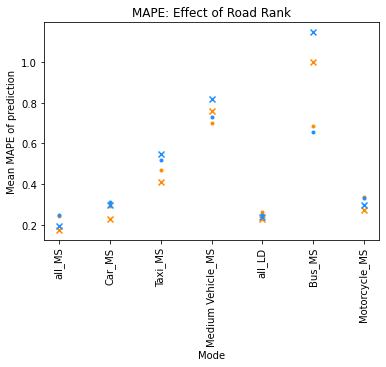

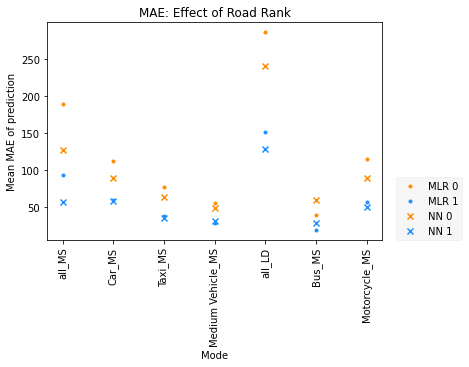

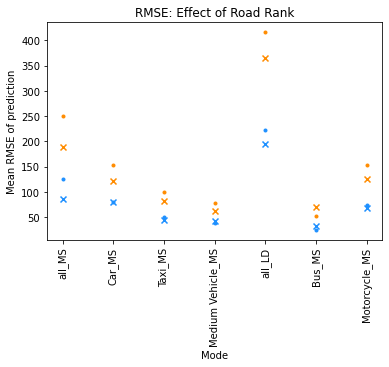

In [18]:
# ROAD RANK PLOTS

colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
# data
subset_ = tmp[#(tmp['Mode']=='all_MS') & \
              (tmp.Method.isin(['MLR','NN'])) & \
                 (~tmp.Var.isin(['vTarget','vOrig'])) & (tmp.Pol!='total')]
subset = subset_.groupby(by=['Mode','Method','road_rank']).mean().drop(columns=['Run'])

for vi,v in enumerate(['MAPE','MAE','RMSE']):
    xxx = subset.loc[:,:,:,:,:][v]
    plt.figure()
    for mi,m in enumerate(['MLR','NN']):
        for ai,a in enumerate([0,1]): # buslane vs no buslane if no busstops
            for si,s in enumerate(set(tmp['Mode'])):
                plt.scatter(s,xxx.loc[s,m,a],color=colors[ai],marker=markers[mi],label='%s %s'%(m,a))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if vi==1:
        plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray',loc=(1.04,0))
    plt.title('%s: Effect of Road Rank'%v)
    plt.xlabel('Mode'); plt.ylabel('Mean %s of prediction'%v)
    plt.xticks(rotation='vertical')
    #plt.savefig('r3_RoadRank_%s.pdf'%v, format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

#### 5. Polygons / Links

In [19]:
# PLOT 5 - polygons

# merge allall and polygon info
polygons = pd.read_csv('../data/polygons11.csv')
print(polygons.columns.values)
tmp = pd.merge(allall, polygons, how="left", left_on='Pol',right_on='name')
display(tmp.tail(3))

# 6.a. check if high variance in accuracy
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Pol!='total') & (allall.Var.isin(['q','k']))]
subset = subset_.groupby(by=['Method','Pol','Mode']).mean().drop(columns='Run')
for err in ['MAPE']:
    grouped = subset.loc[:,:,:].unstack()[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)  

# 6.b. mean mape for q k for MLR NN
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Pol!='total') & (allall.Var.isin(['q','k']))]
subset = subset_.groupby(by=['Method','Mode','Var','Pol']).mean().drop(columns='Run')
for err in ['MAPE']:
    grouped = subset.loc[:,'all_MS',:,:].unstack()[err]\
    .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)  

# 6.c.
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Pol!='total') \
                 #& (allall['Mode'].isin(['all_MS']))\
                 #& (allall['Scenario'].isin(['Scen1_qk']))\
                 & (allall.Var.isin(['q','k']))\
                ]
# find standard deviations
subset = subset_.groupby(by=['Method','Pol','Run']).mean()#.drop(columns='Run')
for a in ['MLR','NN']:
    print('\nMean and strandard deviation - ',a)
    for m in set(subset_['Pol']):
        print( m,'Val: %s, Std: %s'%(round(subset.loc[a,m,]['MAPE'].mean(),2), round(np.std(subset.loc[a,m,]['MAPE']),2)))
    print( 'Val: %s, Std: %s'%(round(subset.loc[a,]['MAPE'].mean(),2), round(np.std(subset.loc[a,]['MAPE']),2)))
# frames
for err in ['MAPE']:
    grouped = subset.loc[:,:].unstack()[err]\
    .style.background_gradient(vmin=0.0, vmax=0.7, cmap="YlGnBu").set_precision(2)\
    .applymap(lambda x: 'background-color: white' if pd.isnull(x) else '')
    print('Results for',err)
    display(grouped)  


['polygon' 'name' 'p0_lat_frontleft' 'p0_lon_frontleft'
 'p0_lat_frontright' 'p0_lon_frontright' 'p0_lat_backright'
 'p0_lon_backright' 'p0_lat_backleft' 'p0_lon_backleft' 'length' 'lanes'
 'direction' 'busstops' 'seplane' 'comment' 'complexity' 'road_rank']


,Scenario,Method,Params,Pol,Run,Mode,Var,Outliers,FDFactor,MAE,...,p0_lat_backleft,p0_lon_backleft,length,lanes,direction,busstops,seplane,comment,complexity,road_rank
143037,Scen0_qk,NNFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]",polygon_r7,9,all_MS,k,2,0.6,13.126486,...,37.987771,23.727769,0.095,2.0,220.0,0.0,0.0,,1.0,0.0
143038,Scen0_qk,NNFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]",polygon_r7,9,all_MS,vOrig,2,0.6,2.836285,...,37.987771,23.727769,0.095,2.0,220.0,0.0,0.0,,1.0,0.0
143039,Scen0_qk,NNFD,"[D, 1.9, 1.9, 1.6, -0.4, 0, 0.6]",polygon_r7,9,all_MS,vTarget,2,0.6,2.216030,...,37.987771,23.727769,0.095,2.0,220.0,0.0,0.0,,1.0,0.0


Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\455304645.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\


Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\455304645.py:24: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0, cmap="YlGnBu").set_precision(2)\



Mean and strandard deviation -  MLR
polygon_r8 Val: 0.38, Std: 0.01
polygon_r5 Val: 0.43, Std: 0.01
polygon_r10 Val: 0.44, Std: 0.01
polygon_r6 Val: 0.43, Std: 0.02
polygon_r11 Val: 0.41, Std: 0.02
polygon_r3 Val: 0.4, Std: 0.02
polygon_r1 Val: 0.41, Std: 0.02
polygon_r7 Val: 0.41, Std: 0.01
polygon_r9 Val: 0.41, Std: 0.01
polygon_r0 Val: 0.44, Std: 0.02
polygon_r2 Val: 0.43, Std: 0.02
Val: 0.42, Std: 0.02

Mean and strandard deviation -  NN
polygon_r8 Val: 0.23, Std: 0.03
polygon_r5 Val: 0.43, Std: 0.1
polygon_r10 Val: 0.46, Std: 0.11
polygon_r6 Val: 0.58, Std: 0.08
polygon_r11 Val: 0.4, Std: 0.09
polygon_r3 Val: 0.26, Std: 0.03
polygon_r1 Val: 0.4, Std: 0.09
polygon_r7 Val: 0.45, Std: 0.03
polygon_r9 Val: 0.47, Std: 0.07
polygon_r0 Val: 0.52, Std: 0.13
polygon_r2 Val: 0.42, Std: 0.06
Val: 0.42, Std: 0.13
Results for MAPE


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\455304645.py:45: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(vmin=0.0, vmax=0.7, cmap="YlGnBu").set_precision(2)\


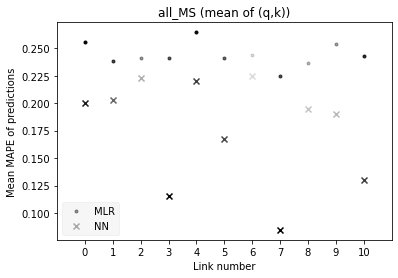

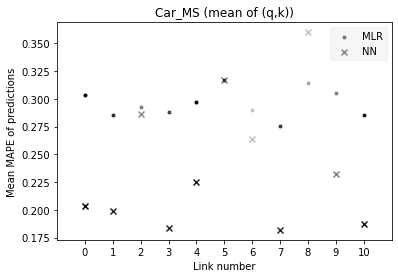

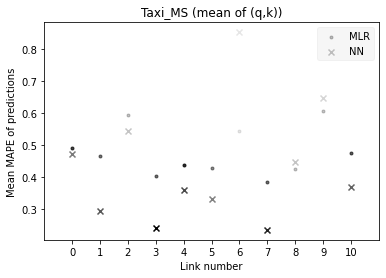

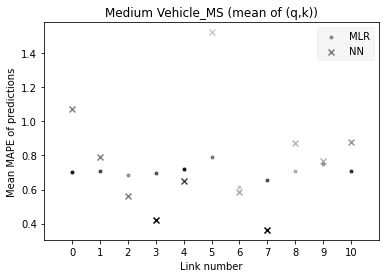

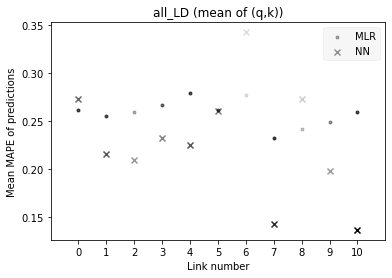

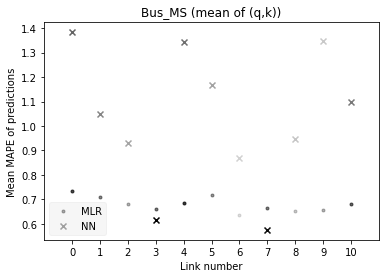

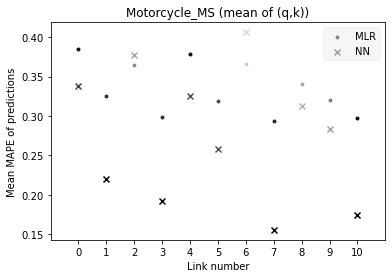

In [20]:
# PLOT POLYGONS

scenariocols = range(1,11)#[1,5,7,10]
scenariocols = ['Scen%s_qk'%i for i in scenariocols]
colors = ['darkorange','dodgerblue','red','darkgreen','green','blue','black','gray','pink','purple']
markers = ['.','x']
err = 'MAPE' # not RMSE by need val without dimension
# data
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Pol!='total') & (allall.Var.isin(['q','k']))].reset_index(drop=True)
subset = subset_.groupby(by=['Method','Pol','Mode']).mean().drop(columns='Run')
subset['avg'] = subset.MAE/subset.MAPE
for m in set(subset_['Mode']):
    subset.loc[(slice(None),slice(None),m),'avg'] /= subset.loc[(slice(None),slice(None),m),'avg'].max()
xxx = subset.loc[:,:,:]#[err]

# color based on MAE/MAPE = MEAN
for mi,m in enumerate(set(allall['Mode'])):
    plt.figure()
    for ai,a in enumerate(['MLR','NN']):
        for pi,p in enumerate(set(subset_.Pol)): # buslane vs no buslane if no busstops
            xpol = int(p[9:])
            xpol -= 1 if xpol>3 else 0
            plt.scatter(xpol,xxx.loc[a,p,m][err],color='black',alpha=xxx.loc[a,p,m]['avg'],marker=markers[ai],label='%s'%(a))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),framealpha=0.2,facecolor='lightgray')
    plt.title('%s (mean of (q,k))'%m)
    plt.xlim(-1,11); plt.xticks(range(11))
    plt.xlabel('Link number'); plt.ylabel('Mean %s of predictions'%err)
    #plt.savefig('r4_%s_Polygons.pdf'%(m), format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

#### 6. Scenario ranking

In [26]:
# EVALUATION OF RESULTS

scenariocols = ['Scen%s_qk'%i for i in scenariocols]
err = 'MAPE'
subset_ = allall[(allall.Method.isin(['MLR','NN'])) & (allall.Var.isin(['q','k'])) & (allall.Pol=='total')]
subset = subset_.groupby(by=['Var','Mode','Method','Scenario']).mean().drop(columns='Run')
xxx = subset.loc[:,:,:,:][err]

# make ranks for each
allranks = []
allvals = []
for scen in range(0,11):
    for v in ['q','k']:
        for a in ['MLR','NN']:
            ranks = []
            for m in ['Bus_MS','Car_MS','Medium Vehicle_MS',\
                      'Motorcycle_MS','Taxi_MS',\
                      'all_LD','all_MS'\
                      ]:# set(subset_['Mode']):
                s = pd.DataFrame(subset.loc[v,m,a,:]['MAPE'])
                #display(s.head())
                #s = s.droplevel(level=[0,1,2])
                s['Scen'] = [int(x[4:-3]) for x in s.index]
                s = s.sort_values('MAPE').reset_index(drop=True)
                if scen in s.Scen.values:
                    idx = s[s.Scen==scen].index[0] + 1
                    ranks.append(   (idx)/len(s) )
                    allvals.append( (idx)/len(s) )
                else:
                    allvals.append(np.nan)
            allranks.append([scen,v,a,np.mean(ranks),ranks])

xxx = []
yyy = []
allranks = pd.DataFrame(allranks,columns=['scen','v','a','avg','rank'])
print('Overall',allranks.groupby(by='scen').mean().sort_values(by='avg'))#.index.values)
xxx.append(allranks.groupby(by='scen').mean().sort_values(by='avg').index.values)
yyy.append(allranks.groupby(by='scen').mean().sort_values(by='avg')['avg'].values)
for a in ['MLR','NN']:
    #for v in ['q','k']:
    allranks2 = allranks[(allranks.a==a)].groupby(by=['scen']).mean()
    print(a,allranks2.sort_values(by='avg'))#.index.values)
    xxx.append(allranks2.sort_values(by='avg').index.values)
    yyy.append(allranks2.sort_values(by='avg')['avg'].values)
    

Overall            avg
scen          
4     0.204545
1     0.281818
7     0.422727
8     0.460000
3     0.476364
2     0.537500
5     0.602841
0     0.665909
10    0.675000
6     0.727273
9     0.915152
MLR            avg
scen          
4     0.159091
1     0.269091
7     0.369091
2     0.456818
3     0.501818
8     0.550909
5     0.627652
6     0.631818
10    0.680303
0     0.693939
9     0.992424
NN            avg
scen          
4     0.250000
1     0.294545
8     0.369091
3     0.450909
7     0.476364
5     0.578030
2     0.618182
0     0.637879
10    0.669697
6     0.822727
9     0.837879


In [27]:
z = pd.DataFrame(xxx,index=['overall','MLR','NN']).T
z['valsO'] = yyy[0]
z['valsMLR'] = yyy[1]
z['valsNN'] = yyy[2]
#pd.set_option('precision', 2)
print(z)
display(z.T\
        .style.background_gradient(axis=1,cmap="YlGnBu").set_precision(2))
#pd.reset_option('precision')
#gmap=zzz[[ "valsO",'valsMLR','valsNN']])\

    overall  MLR  NN     valsO   valsMLR    valsNN
0         4    4   4  0.204545  0.159091  0.250000
1         1    1   1  0.281818  0.269091  0.294545
2         7    7   8  0.422727  0.369091  0.369091
3         8    2   3  0.460000  0.456818  0.450909
4         3    3   7  0.476364  0.501818  0.476364
5         2    8   5  0.537500  0.550909  0.578030
6         5    5   2  0.602841  0.627652  0.618182
7         0    6   0  0.665909  0.631818  0.637879
8        10   10  10  0.675000  0.680303  0.669697
9         6    0   6  0.727273  0.693939  0.822727
10        9    9   9  0.915152  0.992424  0.837879


C:\Users\ga59com\AppData\Local\Temp\ipykernel_15584\3876794693.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .style.background_gradient(axis=1,cmap="YlGnBu").set_precision(2))


,0,1,2,3,4,5,6,7,8,9,10
overall,4.00,1.00,7.00,8.00,3.00,2.00,5.00,0.00,10.00,6.00,9.00
MLR,4.00,1.00,7.00,2.00,3.00,8.00,5.00,6.00,10.00,0.00,9.00
NN,4.00,1.00,8.00,3.00,7.00,5.00,2.00,0.00,10.00,6.00,9.00
valsO,0.20,0.28,0.42,0.46,0.48,0.54,0.60,0.67,0.68,0.73,0.92
valsMLR,0.16,0.27,0.37,0.46,0.50,0.55,0.63,0.63,0.68,0.69,0.99
valsNN,0.25,0.29,0.37,0.45,0.48,0.58,0.62,0.64,0.67,0.82,0.84
